<a href="https://colab.research.google.com/github/KulpitchaS/background-generator/blob/main/10-Unsupervised_04042024_KPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://qph.fs.quoracdn.net/main-qimg-c7e3ab8ca3f5c33f11a0f8828f06d1b2)

* https://www.quora.com/What-is-classification-and-regression-in-machine-learning

We have seen two examples of machine-learning problems so far: regression and classification. Both can be addressed using deep learning and convolutional neural networks. Both are examples of *supervised learning*: the neural network finds its parameters by fitting its output to predefined training outputs.

Supervised learning is troublesome in geoscience problems because we often deal with data from remote measurements and lack immediate access to the ground truth. We solved this problem by generating data for training using either previous manual interpretations or synthetic modeling.

Extracting information from the training data without predefined outputs is also possible. This approach is known as *unsupervised* learning.

![](https://github.com/UT-GEOML/GEO398D/blob/main/Screenshot.png?raw=1)

https://gemini.google.com/

The text above was generated by Gemini, a chatbot developed by Google in response to OpenAI's ChatGPT and based on an LLM (Large Language Model). LLMs are products of unsupervised learning trained on many different text examples to extract patterns and generate human-like texts.

## Revisiting well-log analysis

Let us revisit the well-log data previously used for lithology classification.

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/facies_vectors.csv'
data = pd.read_csv(url)
data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

This time, we will ignore the core analysis information and assume we only have well-log information. What can we learn from it about the rocks in the subsurface?

In [37]:
from sklearn import preprocessing

# select only two logs
x2 = data.loc[:, ['GR', 'PHIND']]
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler()
x2 = scaler.fit(x2).transform(x2)

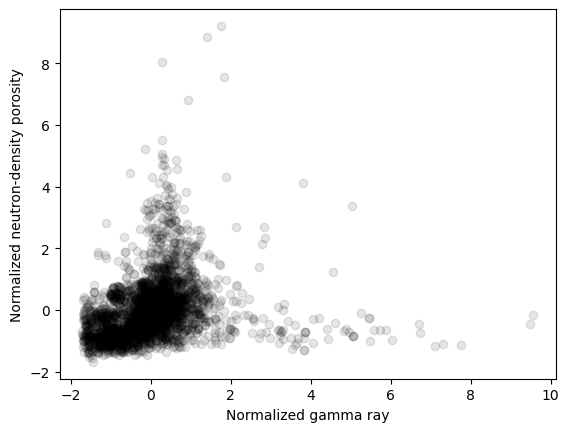

In [38]:
import matplotlib.pyplot as plt

# plot to check
plt.scatter(x2[:, 0], x2[:, 1], color='k', alpha=0.1)
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

Previously, we saw this picture in color, corresponding to different facies. If we don't have access to this information, we can still divide the data points into different classes using clustering analysis.

*Clustering* is a classic example of unsupervised learning.

## Clustering by K-means

We previously used the k-NN (k nearest neighbors) algorithm for classification. A related algorithm, *k-means*, works for unsupervised clustering.

In [4]:
from sklearn.cluster import KMeans

# requested number of clusters
n_clusters = 4

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 n_init='auto',
                 random_state=2024)

In [ ]:
KMeans?

In [5]:
k_means.fit(x2)

KMeans(n_clusters=4, n_init='auto', random_state=2024)

In [6]:
labels = k_means.labels_
print(len(labels), set(labels))

4149 {0, 1, 2, 3}


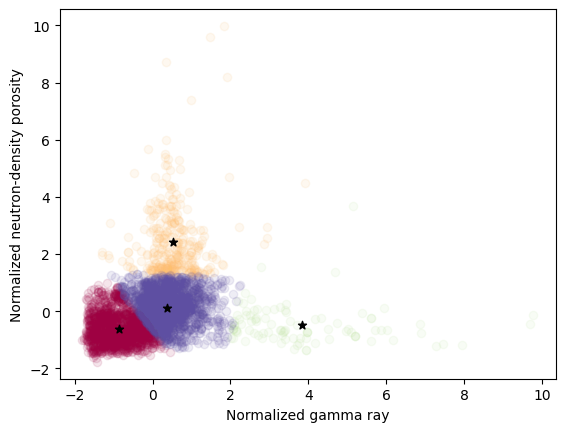

In [7]:
import numpy as np

# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
centers = k_means.cluster_centers_

for k, col in enumerate(colors):
    plt.scatter(x2[labels == k, 0], x2[labels == k, 1], color=col, alpha=0.1)
    # plots the centroids
    plt.scatter(centers[k][0], centers[k][1], color='k', marker='*')
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

## How does it work?

The k-means algorithm looks for $k$ centers (means) and divides the data into clusters, each assigned to the nearest center.

It works iteratively:
1. Start with some distribution of centers, possibly random.
2. Divide the data into clusters and compute the mean point for each cluster.
3. If the mean point of a cluster does not coincide with its center, move the center.
4. Repeat step 2.

As a result, the data space gets partitioned into polygonal regions corresponding to the nearest center (Voronoi diagram).

![](https://mathworld.wolfram.com/images/eps-gif/VoronoiDiagramPlots_800.gif)
* https://mathworld.wolfram.com/VoronoiDiagram.html

In [10]:
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(colors)
scatter_colors = [colors[c] for c in labels]
xc = [centers[:]]

# create 400 x 400 grid
G = np.linspace(x2[:, 0].min(), x2[:, 0].max(), 400)
R = np.linspace(x2[:, 0].min(), x2[:, 1].max(), 400)
G, R = np.meshgrid(G, R)
# find a cluster for every point
grid = np.array([G.ravel(), R.ravel()]).T
F = k_means.predict(grid).reshape(G.shape)

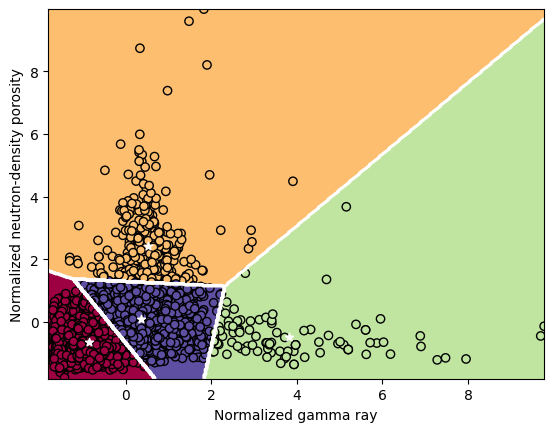

In [11]:
# overlay map and scatter plot
plt.contourf(G, R, F, cmap=cmap)
plt.contour(G, R, F, linewidths=2, colors='w')
plt.scatter(x2[:, 0], x2[:, 1], c=scatter_colors, edgecolors='k')
plt.scatter(centers[:, 0], centers[:, 1], color='w', marker='*')
plt.axis([G.min(), G.max(), R.min(), R.max()])
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

Do different regions correspond to different rocks? Not necessarily. Nevertheless, the clusters allow us to group all data points into specific categories.

## Deciding on the number of clusters

The immediate measure for evaluating k-means clustering is *inertia*, which is the sum of the squared distances between each point and its nearest cluster center.

We can use inertia to estimate an appropriate number of clusters.

In [12]:
print(k_means.inertia_, k_means.score(x2))

2781.858429845614 -2781.858429845614


In [13]:
inertias = []
ks = list(range(2, 9))
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=2024)
    km.fit(x2)
    inertias.append(km.inertia_)

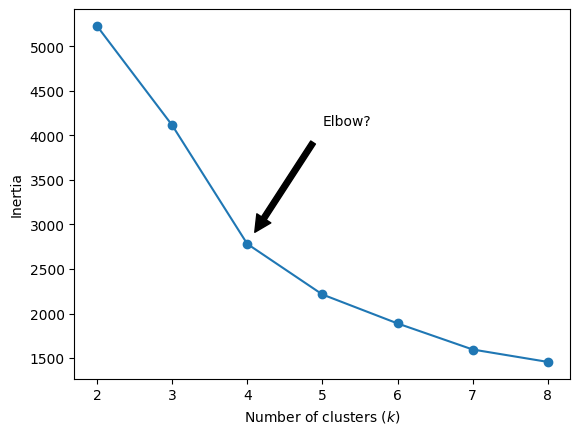

In [14]:
plt.plot(ks, inertias, 'o-')
plt.annotate('Elbow?',
             xy=(4, inertias[2]),
             xytext=(5, inertias[1]),
             arrowprops={'facecolor': 'black', 'shrink': 0.1})
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Inertia')
plt.show()

## <div style="color:red">Task 1</div>

Instead of using only two logs <code>['GR', 'ILD_log10']</code>, perform clustering using five logs <code>['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']</code>, dropping wells that don't have PE logs.

You cannot plot clustering results in the 5-D space, but you can plot inertia to determine the optimal number of clusters.

In [16]:
from sklearn import preprocessing
data.dropna(subset=['PE'],inplace=True)
# select only two logs
x3 = data.loc[:, ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']]
#x2.PE.unique()

In [17]:
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler()
x3 = scaler.fit(x3).transform(x3)

In [18]:
from sklearn.cluster import KMeans

# requested number of clusters
n_clusters = 4

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 n_init='auto',
                 random_state=2024)
k_means.fit(x3)

KMeans(n_clusters=4, n_init='auto', random_state=2024)

In [19]:
# Decide number of clusters/plot inertia
print(k_means.inertia_, k_means.score(x3))

7852.40832099153 -7852.40832099153


In [21]:
inertias = []
ks = list(range(2, 20))
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=2024)
    km.fit(x3)
    inertias.append(km.inertia_)

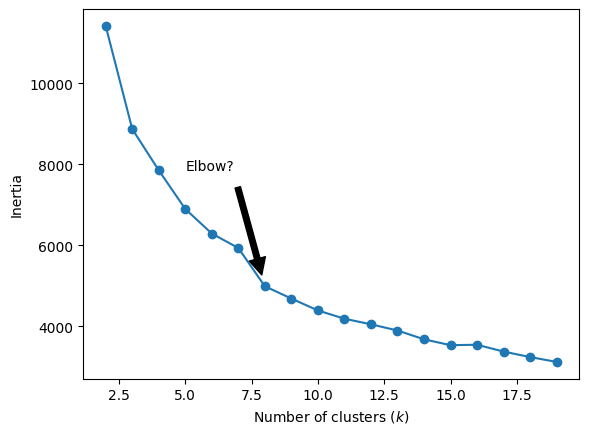

In [22]:
plt.plot(ks, inertias, 'o-')
plt.annotate('Elbow?',
             xy=(8, inertias[6]),
             xytext=(5, inertias[2]),
             arrowprops={'facecolor': 'black', 'shrink': 0.1})
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Inertia')
plt.show()

In [23]:
from sklearn.cluster import KMeans

# requested number of clusters
n_clusters = 8

# use random_state for reproducibility
k_means2 = KMeans(n_clusters=n_clusters,
                 n_init='auto',
                 random_state=2024)
k_means2.fit(x3)

KMeans(n_init='auto', random_state=2024)

In [24]:
labels2 = k_means2.labels_
print(len(labels2), set(labels2))

3232 {0, 1, 2, 3, 4, 5, 6, 7}


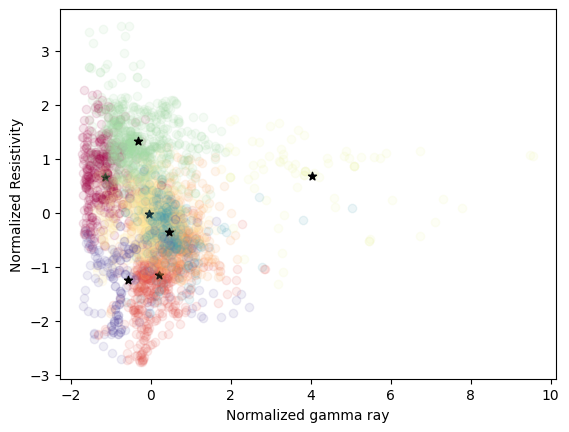

In [30]:
import numpy as np

# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
centers = k_means2.cluster_centers_

for k, col in enumerate(colors):
    plt.scatter(x3[labels2 == k, 0], x3[labels2 == k, 1], color=col, alpha=0.1)
    # plots the centroids
    plt.scatter(centers[k][0], centers[k][1], color='k', marker='*')
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized Resistivity')
plt.show()

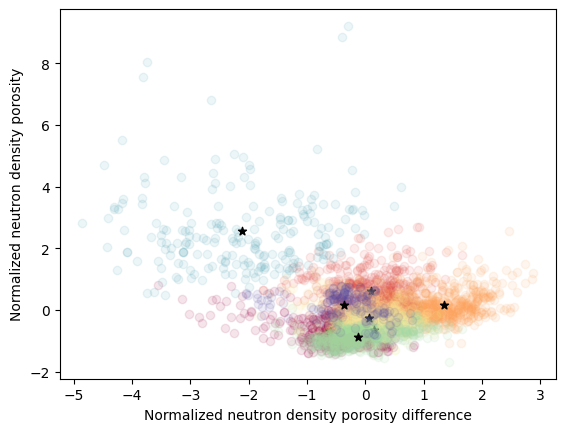

In [27]:
# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
centers = k_means2.cluster_centers_

for k, col in enumerate(colors):
    plt.scatter(x3[labels2 == k, 2], x3[labels2 == k, 3], color=col, alpha=0.1)
    # plots the centroids
    plt.scatter(centers[k][2], centers[k][3], color='k', marker='*')
plt.xlabel('Normalized neutron density porosity difference')
plt.ylabel('Normalized neutron density porosity')
plt.show()

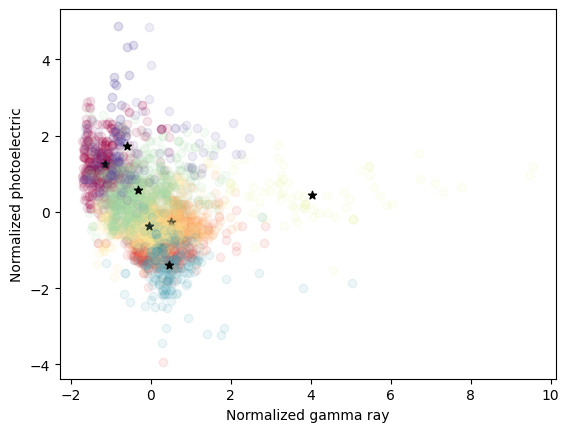

In [28]:
# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
centers = k_means2.cluster_centers_

for k, col in enumerate(colors):
    plt.scatter(x3[labels2 == k, 0], x3[labels2 == k, 4], color=col, alpha=0.1)
    # plots the centroids
    plt.scatter(centers[k][0], centers[k][4], color='k', marker='*')
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized photoelectric')
plt.show()

We can test if there is any statistical dependence between our clusters and lithofacies using the statistical chi-squared ($\chi^2$) test.

* https://en.wikipedia.org/wiki/Chi-squared_test

In [32]:
data['Clusters'] = labels2
contingency = pd.crosstab(data.Facies, data.Clusters)
contingency

Clusters    0    1    2    3   4    5    6   7
Facies                                        
1           0  178    9   69   0    1    2   0
2           0  175  219  282   0    9   52   1
3           6  123  225  104   1   10  143   3
4           3    2   41   64  28   44    1   1
5          20   10   16   24  10  127    7   3
6          84    6   16   61   7  281    0   7
7           5   25   13   27  10    0    3  15
8         221   10    7   73  11  106    6  64
9          68    0    0    1   6    9    0  77

In [33]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(contingency)
print(pd.DataFrame(expected))
print('statistic = {}, '
      'p-value = {}, '
      'degress of freedom = {}'.format(stat, p, dof))

           0           1           2           3          4           5  \
0  32.615408   42.392017   43.754332   56.495978   5.849938   47.039913   
1  92.935025  120.792698  124.674505  160.980817  16.668936  134.036510   
2  77.445854  100.660582  103.895421  134.150681  13.890780  111.697092   
3  23.170792   30.116337   31.084158   40.136139   4.155941   33.418317   
4  27.326423   35.517636   36.659035   47.334468   4.901300   39.411819   
5  58.178837   75.618193   78.048267  100.776609  10.435025   83.909035   
6  12.340965   16.040223   16.555693   21.376856   2.213490   17.798886   
7  62.712252   81.510520   84.129950  108.629332  11.248144   90.447401   
8  20.274443   26.351795   27.198639   35.119121   3.636448   29.241027   

           6          7  
0  17.149134  13.703280  
1  48.865099  39.046411  
2  40.720916  32.538676  
3  12.183168   9.735149  
4  14.368193  11.481126  
5  30.590347  24.443688  
6   6.488861   5.185025  
7  32.974010  26.348391  
8  10.660272   

In [34]:
data.Facies.unique()

array([3, 2, 8, 6, 7, 4, 5, 9, 1])

Small $p$-value justifies rejecting the null hypothesis of statistical independence. It appears that clusters and lithofacies are indeed dependent.

In [ ]:
chi2_contingency?

## Clustering by DBSCAN

Of course, k-means is not the only clustering algorithm. There is a variety of other options.

We can try, for example, DBSCAN (Density-Based Spatial Clustering of Applications with Noise). Unlike k-means, DBSCAN is a deterministic algorithm. It looks for high-density data aggregations and expands from them to define clusters.

* Schubert, E., Sander, J., Ester, M., Kriegel, H.P. and Xu, X., 2017. [DBSCAN revisited, revisited: why and how you should (still) use DBSCAN](https://dl.acm.org/doi/10.1145/3068335). ACM Transactions on Database Systems (TODS), 42(3), pp.1-21.

In [45]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.4, min_samples=10).fit(x2)
set(db.labels_)

{-1, 0, 1}

In [46]:
DBSCAN?

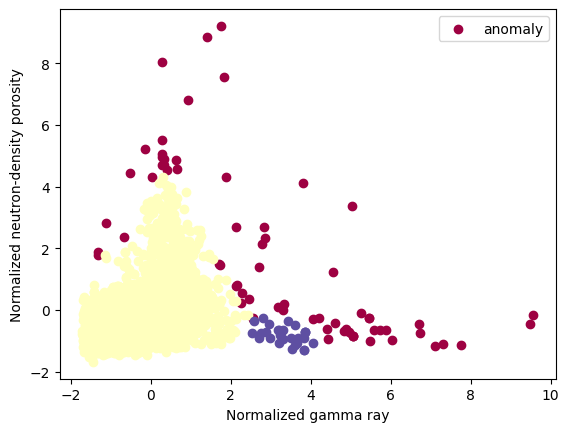

In [47]:
# find number of clusters
n_db_clusters = len(set(db.labels_))
# set colors
db_colors = plt.cm.Spectral(np.linspace(0, 1, n_db_clusters))

for k in range(n_db_clusters):
    plt.scatter(x2[db.labels_ == k-1, 0],
                x2[db.labels_ == k-1, 1],
                color=db_colors[k],
                label=(None, 'anomaly')[k == 0])
plt.legend()
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

### For 5 logs

In [48]:
db2 = DBSCAN(eps=0.4, min_samples=10).fit(x3)
set(db2.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6}

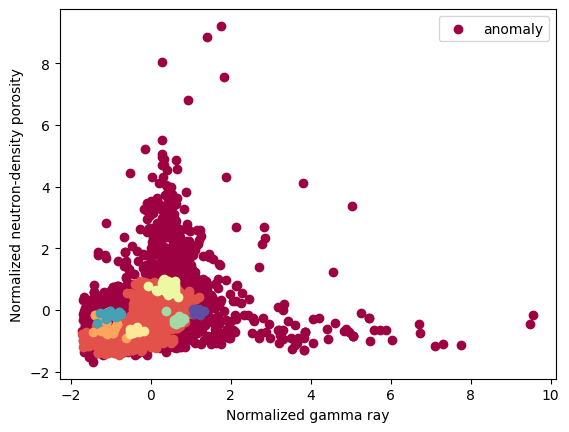

In [50]:
# find number of clusters
n_db2_clusters = len(set(db2.labels_))
# set colors
db2_colors = plt.cm.Spectral(np.linspace(0, 1, n_db2_clusters))

for k in range(n_db2_clusters):
    plt.scatter(x2[db2.labels_ == k-1, 0],
                x2[db2.labels_ == k-1, 1],
                color=db2_colors[k],
                label=(None, 'anomaly')[k == 0])
plt.legend()
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

## Revisiting seismic wavelet analysis

We can also revisit the problem of picking horizons in seismic data. In the supervised setting, we use manual picks of the seafloor horizon as training labels.

In an unsupervised setting, we assume that no picks are available for training. We will extract all wavelets and try to detect patterns in them for clustering analysis.

In [52]:
import os
import numpy as np

# The "seismic.bin" file is available from:
# https://utexas.box.com/s/mfmfgr9n9o7mmkrmh8hvc6w57ynw5d0i
# https://drive.google.com/file/d/1WwBG3hKfdD0UGdXEnbAjG7RnRU9eWkqU/view?usp=sharing

from google.colab import drive
drive.mount('/content/gdrive')
# change the directory name below to your local path
dirname = '/content/gdrive/MyDrive/AppDataGeo'
#dirname = '/content/gdrive/MyDrive'
#dirname = '/users/sfomel/Downloads'

# Seismic data in raw binary format
filename = os.path.join(dirname, 'seismic.bin')

# memmap maps memory of the file on disk to a numpy array
nt, nx, ny = 2001, 1161, 601
seismic = np.memmap(filename, dtype=np.int16, shape=(ny, nx, nt))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers

def plot_seismic(section, title, cmap='gray'):
    plt.imshow(section, cmap=cmap, vmin=-2000, vmax=2000, aspect=0.5)
    xticks = np.arange(0, section.shape[1], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)
    yticks = np.arange(0, section.shape[0], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)
    plt.title(title, fontsize=20)

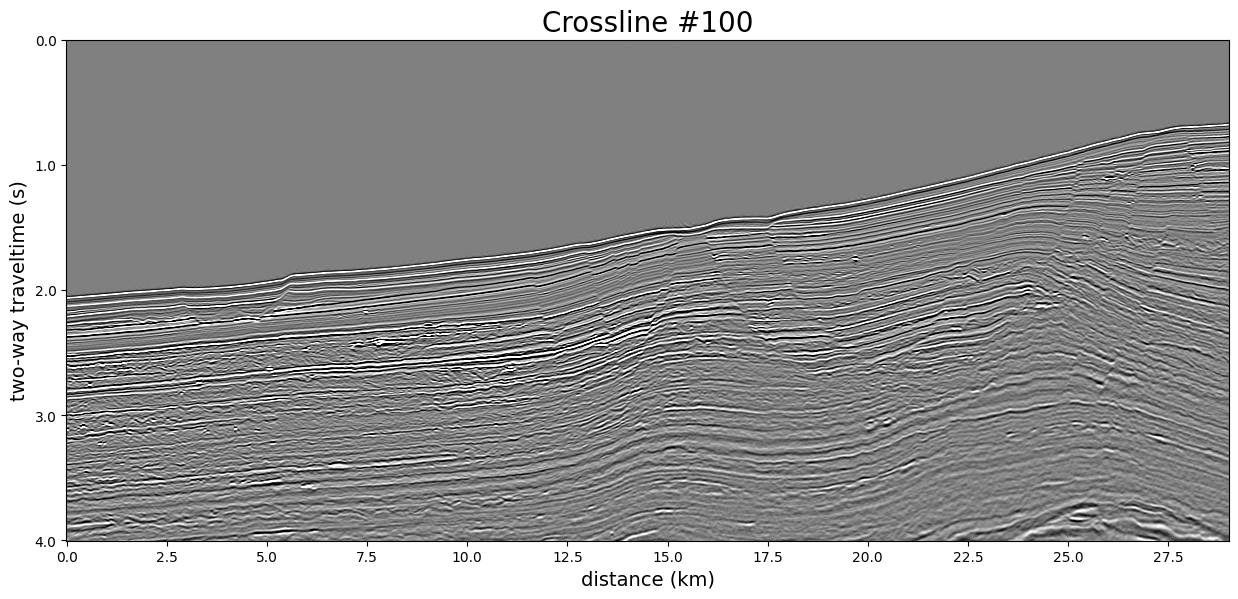

In [54]:
section = seismic[100,:,:1001].T

plt.figure(figsize=(15, 9))
plot_seismic(section, 'Crossline #100')
plt.show()

For extracting wavelets, we can use local maxima of the envelope attribute.

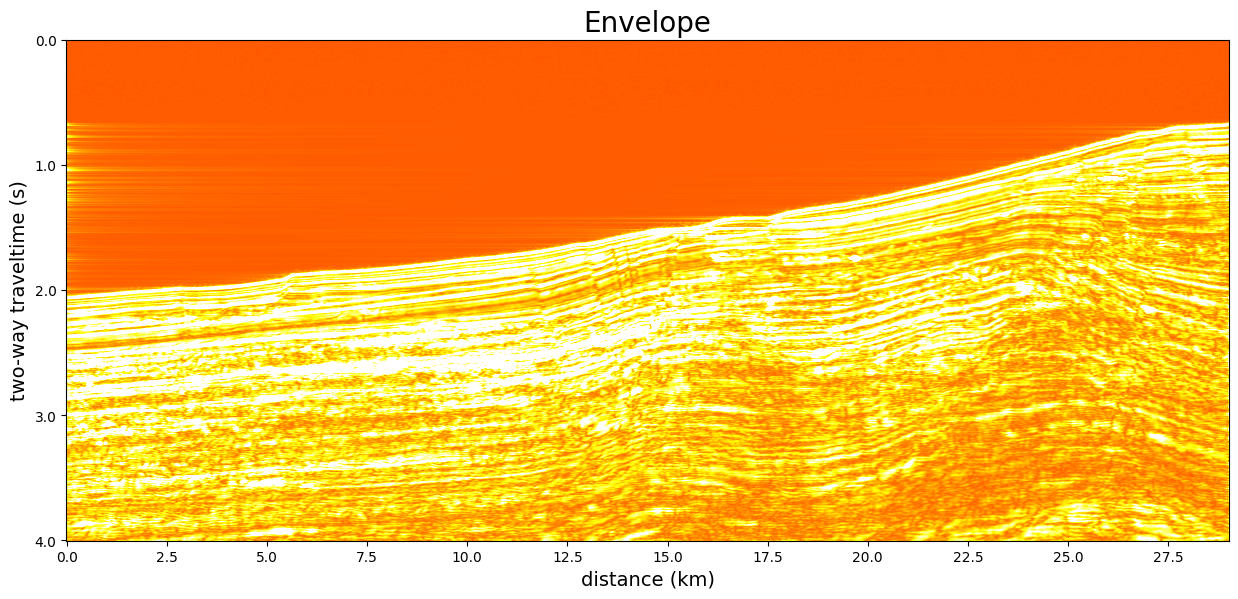

In [55]:
from scipy.signal import hilbert
envelope = np.abs(hilbert(section))

plt.figure(figsize=(15, 9))
plot_seismic(envelope, 'Envelope', cmap='hot')
plt.show()

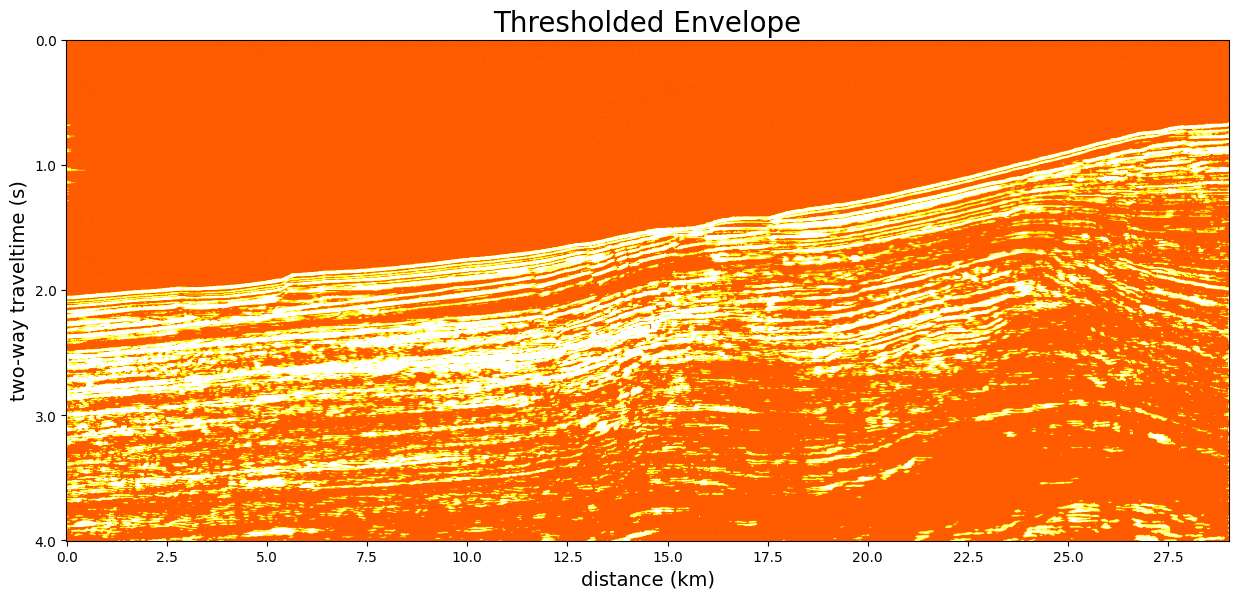

In [56]:
# keep only envelope above 90% percentile
threshold = np.quantile(envelope, 0.8)
envelope_t = envelope[:]
envelope_t[envelope < threshold] = 0

plt.figure(figsize=(15, 9))
plot_seismic(envelope_t, 'Thresholded Envelope', cmap='hot')
plt.show()

In [57]:
from scipy.signal import find_peaks

wavelets = []
picks = []

nw = 41      # wavelet length
ntmax = 1001 # maximum time samples

ntraces = section.shape[1]
for k in range(ntraces):
    trace = section[:, k]
    etrace = envelope_t[:, k]
    # find local maxima
    peaks, _ = find_peaks(etrace)
    for peak in peaks:
        if peak > nw and peak < ntmax-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            if wavelet[nw//2] == wavelet.max():
                wavelets.append(wavelet)
                picks.append((k, peak))

print(f'Extracted {len(wavelets)} wavelets')

Extracted 7539 wavelets


In [58]:
def plot_wavelets(wavelets, traces, title):
    nw = len(wavelets[0])
    ncols = len(traces)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
    twt = np.arange(-nw//2+1, nw//2+1)*dt
    for trace in range(ncols):
        axt = ax[trace]
        # plot as curve
        amp = wavelets[traces[trace]]
        axt.plot(amp, twt, 'k')
        axt.set_ylim(twt.max(), twt.min())
        if trace == 0:
            axt.set_ylabel('Time (s)')
        else:
            axt.set_yticklabels([])
        axt.set_xticks([])
    f.suptitle(title, fontsize=25)
    plt.show()

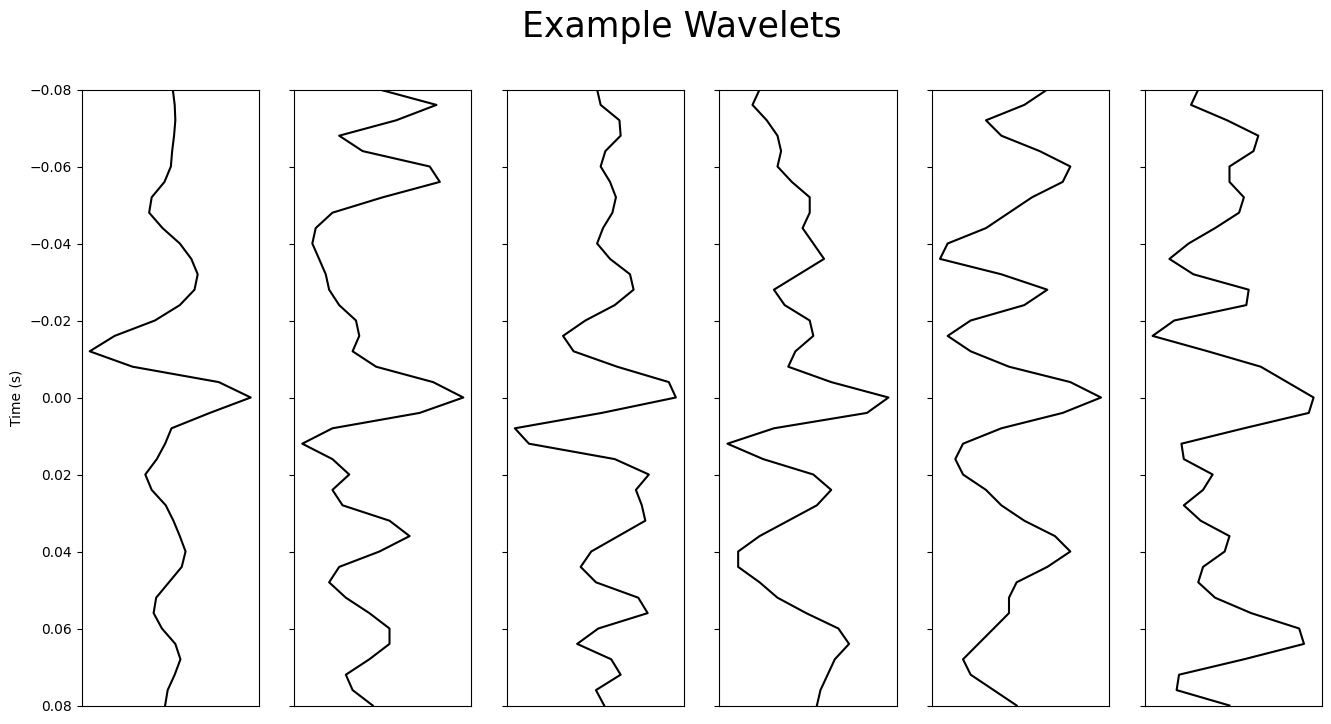

In [59]:
plot_wavelets(wavelets, np.arange(1000, 1501, 100), 'Example Wavelets')

We could cluster 7,539 wavelets directly (in 41-dimensional space), but the wavelets contain details that may not be important for their identification. It is better to extract their essential patterns by first projecting them to a lower-dimensional space.

## Principal Component Analysis

PCA (Principal Component Analysis) projects the data into a lower-dimensional space using SVD (Singular Value Decomposition), a classic tool from numerical linear algebra.

* https://en.wikipedia.org/wiki/Singular_value_decomposition

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/512px-Singular_value_decomposition_visualisation.svg.png)

In [60]:
from sklearn.decomposition import PCA
wavelets = np.array(wavelets)


pca = PCA()
pca.fit(wavelets)

PCA()

In [ ]:
PCA?

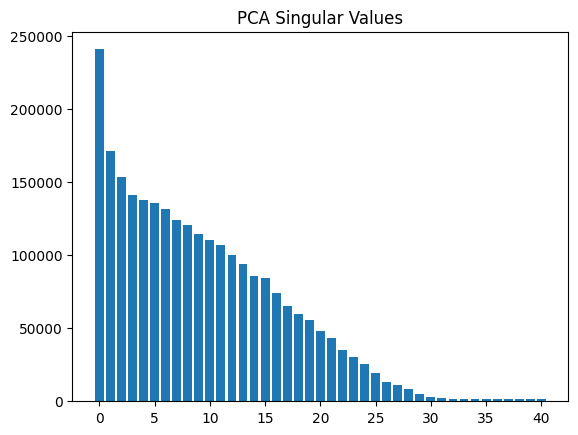

In [61]:
plt.bar(np.arange(nw), pca.singular_values_)
plt.title('PCA Singular Values')
plt.show()

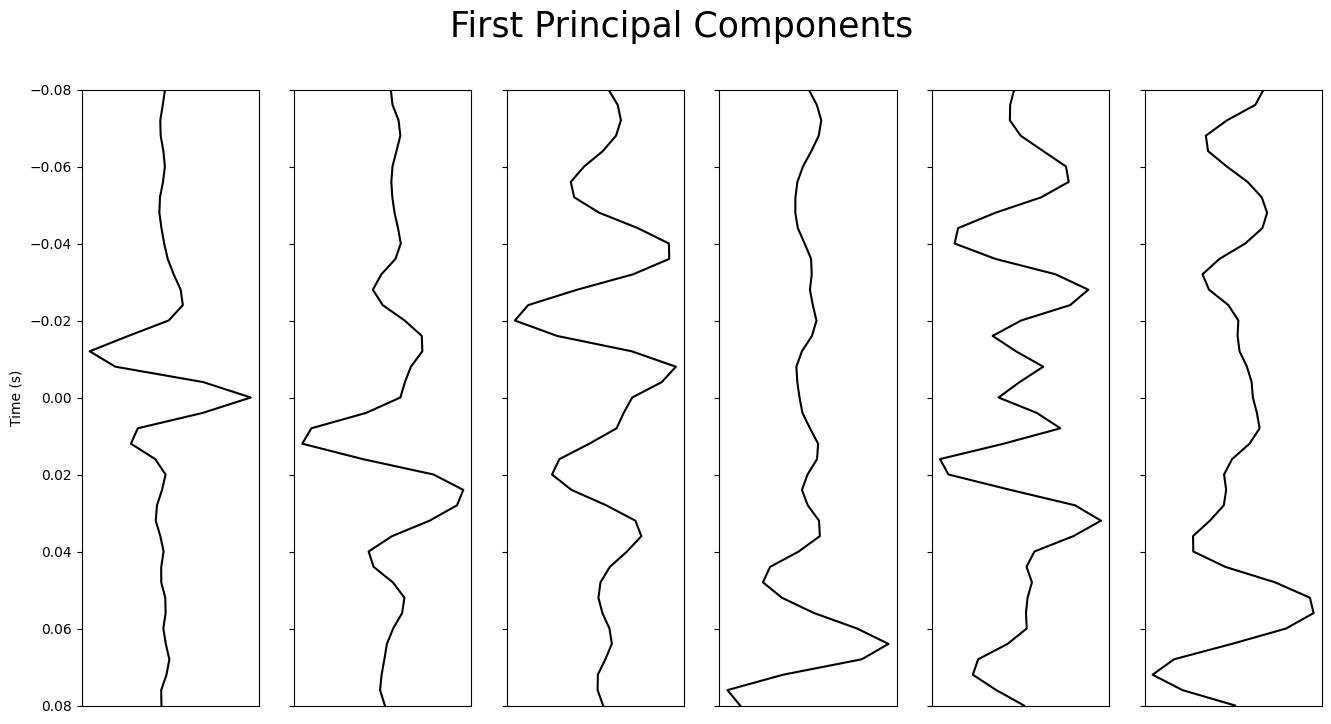

In [62]:
plot_wavelets(pca.components_, np.arange(6), 'First Principal Components')

In [63]:
pca12 = PCA(n_components=12)
wavelets12 = pca12.fit_transform(wavelets)
wavelets12.shape

(7539, 12)

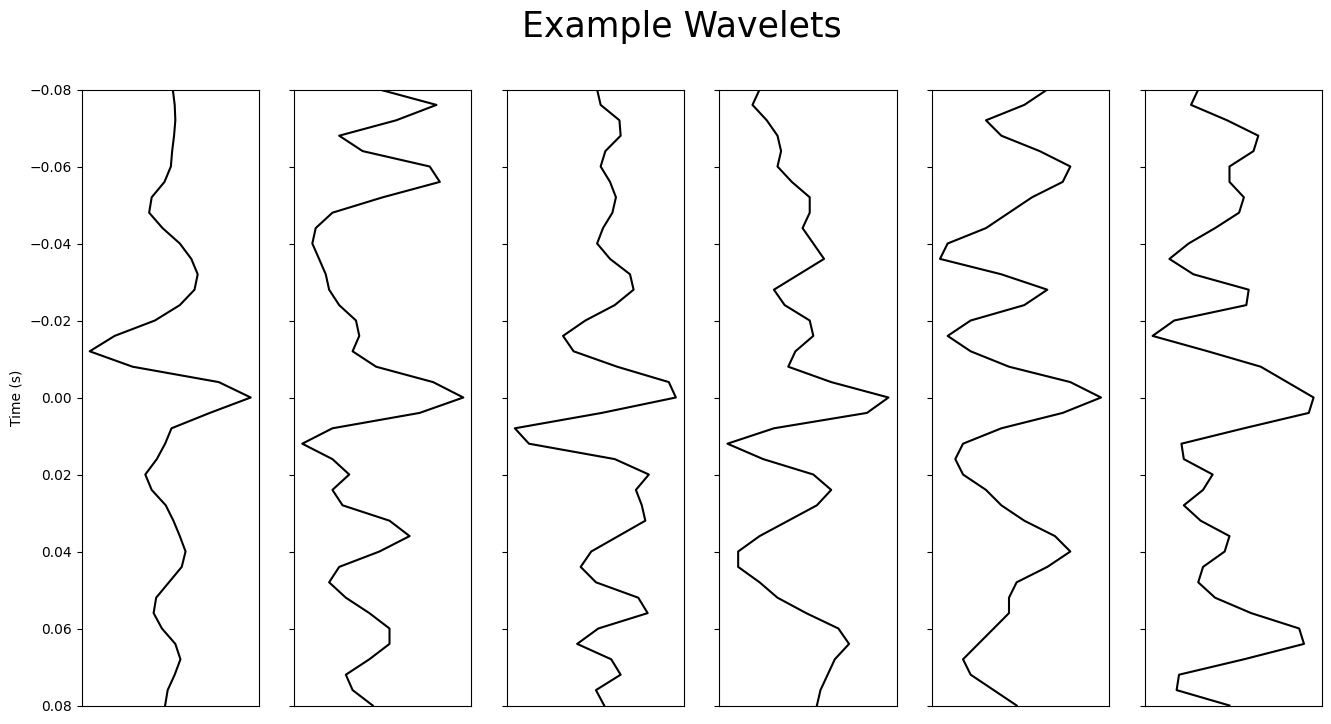

In [64]:
wavelets_pca = pca12.inverse_transform(wavelets12)

plot_wavelets(wavelets, np.arange(1000, 1501, 100), 'Example Wavelets')

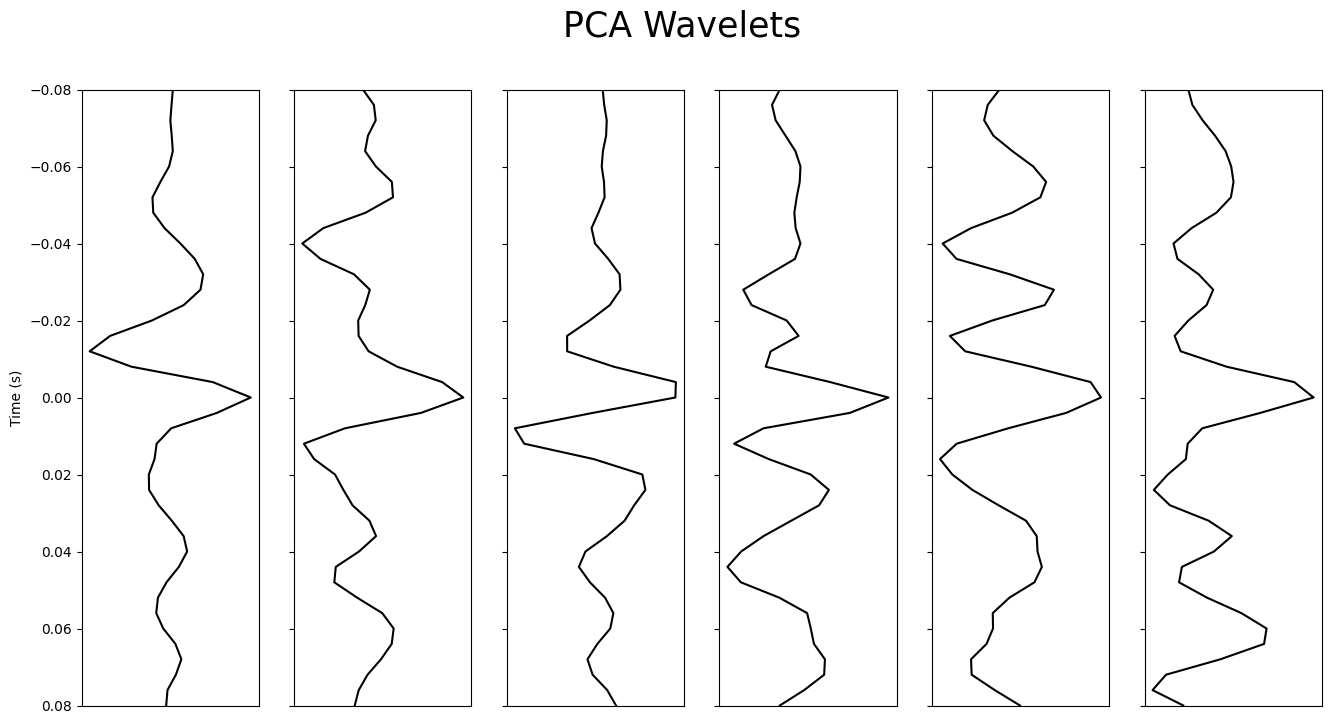

In [65]:
plot_wavelets(wavelets_pca, np.arange(1000, 1501, 100), 'PCA Wavelets')

Having reduced the dimensionality from 41 to 12 by removing unimportant details, we can perform a better job of clustering our data, now in the 12-dimensional space.

## Autoencoder

PCA is a powerful dimensionality-reduction technique, but the linearity assumption limits its power. A more powerful approach involves neural networks.

Recall the simple network we used for classifying wavelets.

In [66]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

We reduced the data size inside the classification network to extract the most essential patterns. The idea of *autoencoding* is to follow this reduction (encoding) with an extension back to the original size (decoding) and fit the original data.

![](https://miro.medium.com/max/4800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

In [67]:
input_wavelets = keras.Input(shape=(nw,))
encoded = keras.layers.Dense(12, activation='relu')(input_wavelets)
decoded = keras.layers.Dense(nw, activation='tanh')(encoded)

encoder = keras.Model(input_wavelets, encoded)
autoencoder = keras.Model(input_wavelets, decoded)

encoded_input = keras.Input(shape=(12,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                504       
                                                                 
 dense_3 (Dense)             (None, 41)                533       
                                                                 
Total params: 1037 (4.05 KB)
Trainable params: 1037 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Because we are going to be fitting the input dataset to itself, we can treat it as a regression problem (technically, autoregression) and use MSE (mean squared error) as the loss function.

In [68]:
autoencoder.compile(loss='mse', optimizer='adam')

We can prepare the data for training by randomly shuffling and normalizing the wavelets by maximum value.

In [69]:
import tensorflow.random
import random

# for reproducibility
tensorflow.random.set_seed(2024)
np.random.seed(2024)
random.seed(2024)

# randomly shuffle wavelets and picks together
zipped = list(zip(wavelets, picks))
random.shuffle(zipped)
wavelets_r, picks_r = zip(*zipped)

# convert to numpy and normalize by maximum
wavelets_n = np.array(wavelets_r)
wavelets_n = wavelets_n/np.max(wavelets_n)

In [70]:
# fit the model
batch_size = 10
epochs = 10

# autoencoder fits data to itself
fit = autoencoder.fit(wavelets_n, wavelets_n,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.3)

Epoch 1/10
528/528 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 2/10
528/528 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 9.1183e-04
Epoch 3/10
528/528 [==============================] - 1s 2ms/step - loss: 8.1777e-04 - val_loss: 8.0269e-04
Epoch 4/10
528/528 [==============================] - 1s 2ms/step - loss: 7.6198e-04 - val_loss: 7.7269e-04
Epoch 5/10
528/528 [==============================] - 1s 2ms/step - loss: 7.2060e-04 - val_loss: 6.7694e-04
Epoch 6/10
528/528 [==============================] - 1s 2ms/step - loss: 6.3834e-04 - val_loss: 6.0201e-04
Epoch 7/10
528/528 [==============================] - 2s 4ms/step - loss: 5.5037e-04 - val_loss: 5.6527e-04
Epoch 8/10
528/528 [==============================] - 2s 4ms/step - loss: 5.4138e-04 - val_loss: 5.6505e-04
Epoch 9/10
528/528 [==============================] - 2s 3ms/step - loss: 5.4127e-04 - val_loss: 5.6315e-04
Epoch 10/10
528/528 [===================

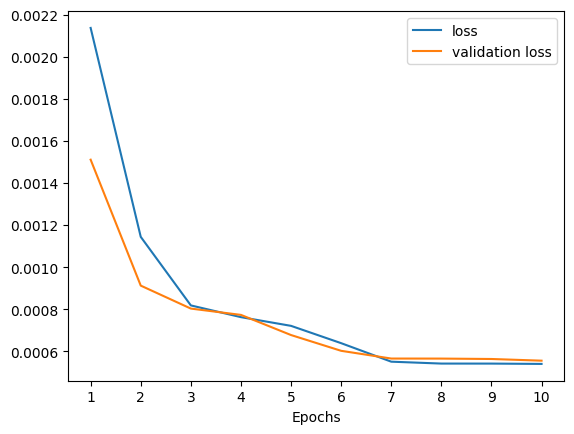

In [71]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

In [72]:
encoded_wavelets = encoder.predict(wavelets_n)
encoded_wavelets.shape

236/236 [==============================] - 1s 2ms/step


(7539, 12)

In [73]:
# Create the decoder model
encoded_input = keras.Input(shape=(12,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

decoded_wavelets = decoder.predict(encoded_wavelets)

236/236 [==============================] - 1s 1ms/step


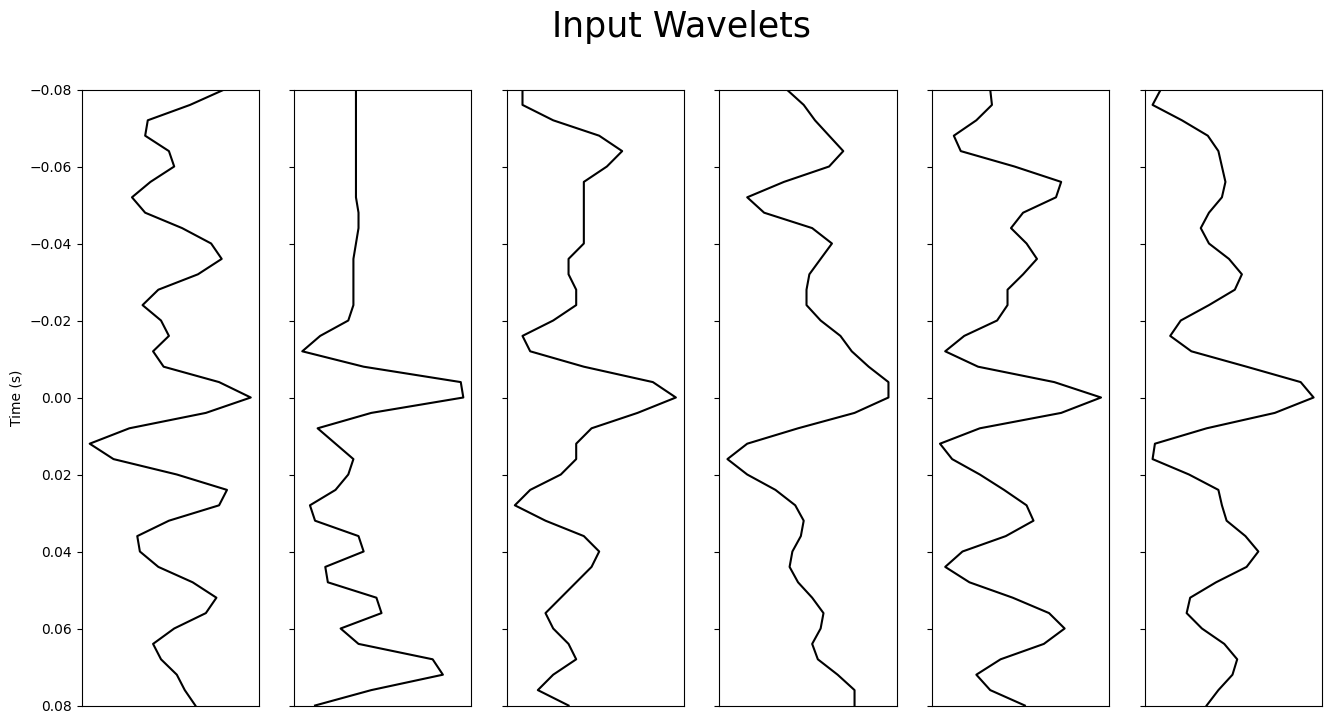

In [74]:
plot_wavelets(wavelets_n, np.arange(1000, 1501, 100), 'Input Wavelets')

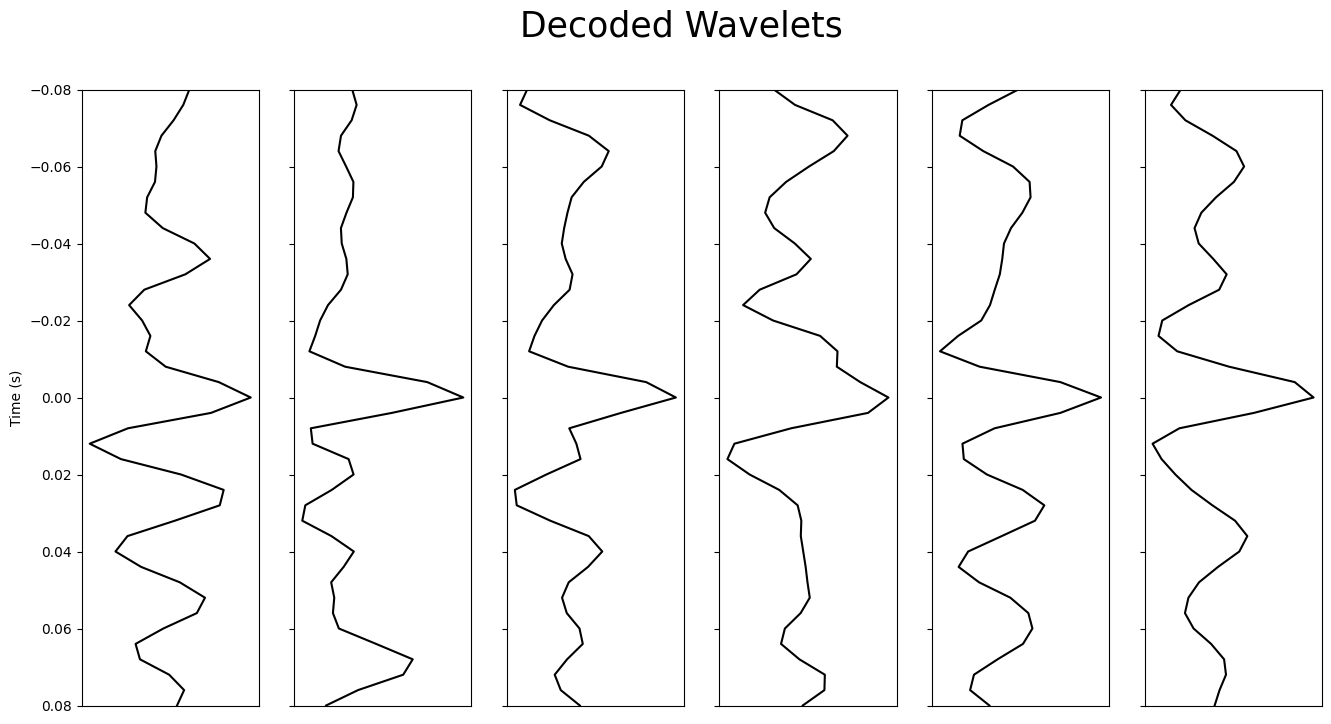

In [75]:
plot_wavelets(decoded_wavelets, np.arange(1000, 1501, 100), 'Decoded Wavelets')

## Clustering latent space

We can now cluster the data in the 12-dimensional latent space using one of the standard clustering techniques, such as k-means.

In [76]:
n_clusters = 5

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 n_init='auto',
                 random_state=2024)
k_means.fit(encoded_wavelets)

KMeans(n_clusters=5, n_init='auto', random_state=2024)

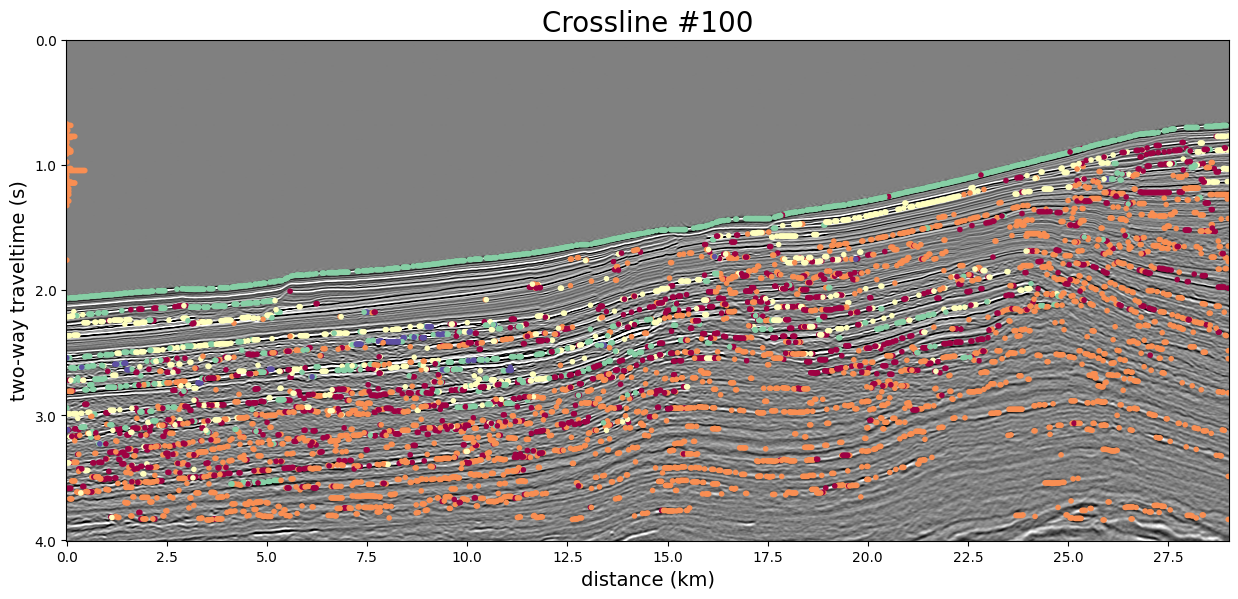

In [77]:
pick_marks = np.array(picks_r)
pick_colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(15, 7.5))
plot_seismic(section, 'Crossline #100')
plt.scatter(pick_marks[:, 0], pick_marks[:, 1],
            color=pick_colors[k_means.labels_],
            marker='.')
plt.show()

Autoencoder-based clustering partially succeeded in picking the seafloor horizon but had less luck with other horizons. It had no prior knowledge of where the horizons should be.

## <div style="color:red">Task 2</div>

Try making the autoencoder network deeper by inserting another hidden layer. For example, instead of going from 41 to 12 in one layer of the encoder part, you can create two layers that go from 41 to 21 and then from 21 to 12. The decoder part will go in the opposite direction: from 12 to 21 and from 21 to 41.

Does it improve the results?

In [79]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.4, min_samples=10).fit(x3)
set(db.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6}

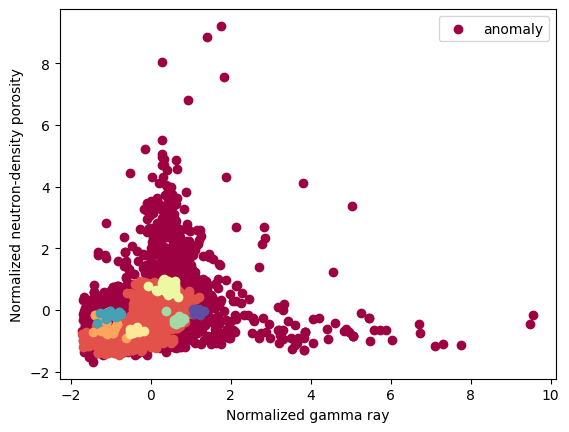

In [80]:
# find number of clusters
n_db_clusters = len(set(db.labels_))
# set colors
db_colors = plt.cm.Spectral(np.linspace(0, 1, n_db_clusters))

for k in range(n_db_clusters):
    plt.scatter(x2[db.labels_ == k-1, 0],
                x2[db.labels_ == k-1, 1],
                color=db_colors[k],
                label=(None, 'anomaly')[k == 0])
plt.legend()
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized neutron-density porosity')
plt.show()

## Variational autoencoder

An extension of the autoencoder idea is *variational autoencoder*, a generative model that can produce multiple data instances by drawing samples from a statistical distribution in the latent space.

* Doersch, C., 2016. [Tutorial on variational autoencoders](https://arxiv.org/abs/1606.05908). arXiv preprint arXiv:1606.05908.

In [82]:
from tensorflow.keras import backend
import keras

latent_dim = 3  # latent space dimensions


class Sampling(keras.layers.Layer):
    'draw sample from distribution'

    def call(self, inputs):
        mean, variance = inputs
        shape = tensorflow.shape(mean)
        epsilon = backend.random_normal(shape=shape)
        return mean + backend.exp(0.5 * variance) * epsilon


# create encoder
inputs = keras.Input(shape=(nw,))
code1 = keras.layers.Dense(21, activation='relu')(inputs)
code2 = keras.layers.Dense(12, activation='relu')(code1)
mean = keras.layers.Dense(latent_dim)(code2)
variance = keras.layers.Dense(latent_dim)(code2)

# latent space draws random samples
latent = Sampling()([mean, variance])
va_encoder = keras.Model(inputs, latent)

In [83]:
# create decoder
latent_inputs = keras.Input(shape=(latent_dim,))
code = keras.layers.Dense(12, activation='relu')(latent_inputs)
code2 = keras.layers.Dense(21, activation='relu')(code1)
outputs = keras.layers.Dense(nw, activation='tanh')(code)
va_decoder = keras.Model(latent_inputs, outputs)

# Variantional autoencoder
outputs = va_decoder(va_encoder(inputs))
vae = keras.Model(inputs, outputs)

In [84]:
vae.compile(loss='mse', optimizer='adam')

batch_size = 10
epochs = 30

# autoencoder fits data to itself
vae_fit = vae.fit(wavelets_n, wavelets_n,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.3)

Epoch 1/30
528/528 [==============================] - 5s 6ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 2/30
528/528 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/30
528/528 [==============================] - 2s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/30
528/528 [==============================] - 3s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/30
528/528 [==============================] - 2s 4ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/30
528/528 [==============================] - 2s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/30
528/528 [==============================] - 2s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/30
528/528 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/30
528/528 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/30
528/528 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0016

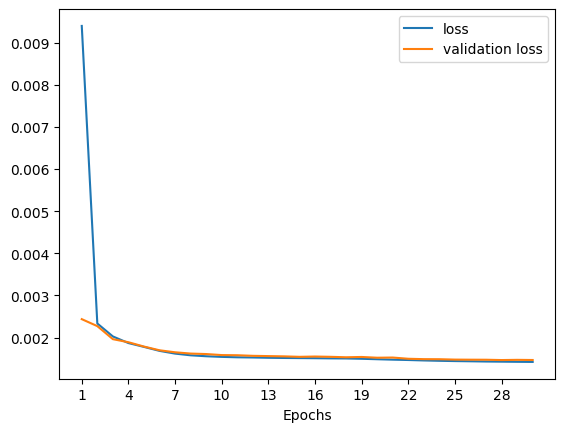

In [85]:
plot_loss(vae_fit, epochs)

In [91]:
encoded_vae_wavelets = encoder.predict(wavelets_n)
encoded_vae_wavelets.shape

236/236 [==============================] - 1s 3ms/step


(7539, 12)

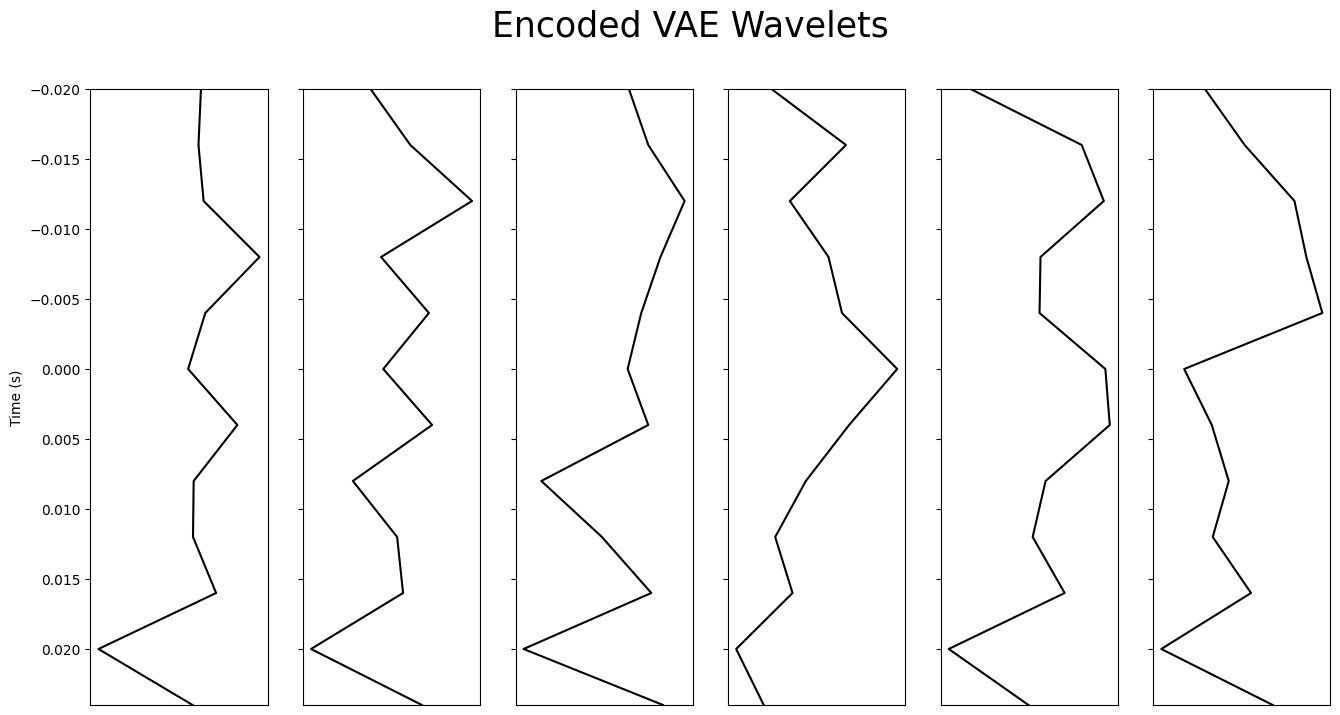

In [92]:
plot_wavelets(encoded_vae_wavelets, np.arange(6), 'Encoded VAE Wavelets')

1/1 [==============================] - 0s 37ms/step


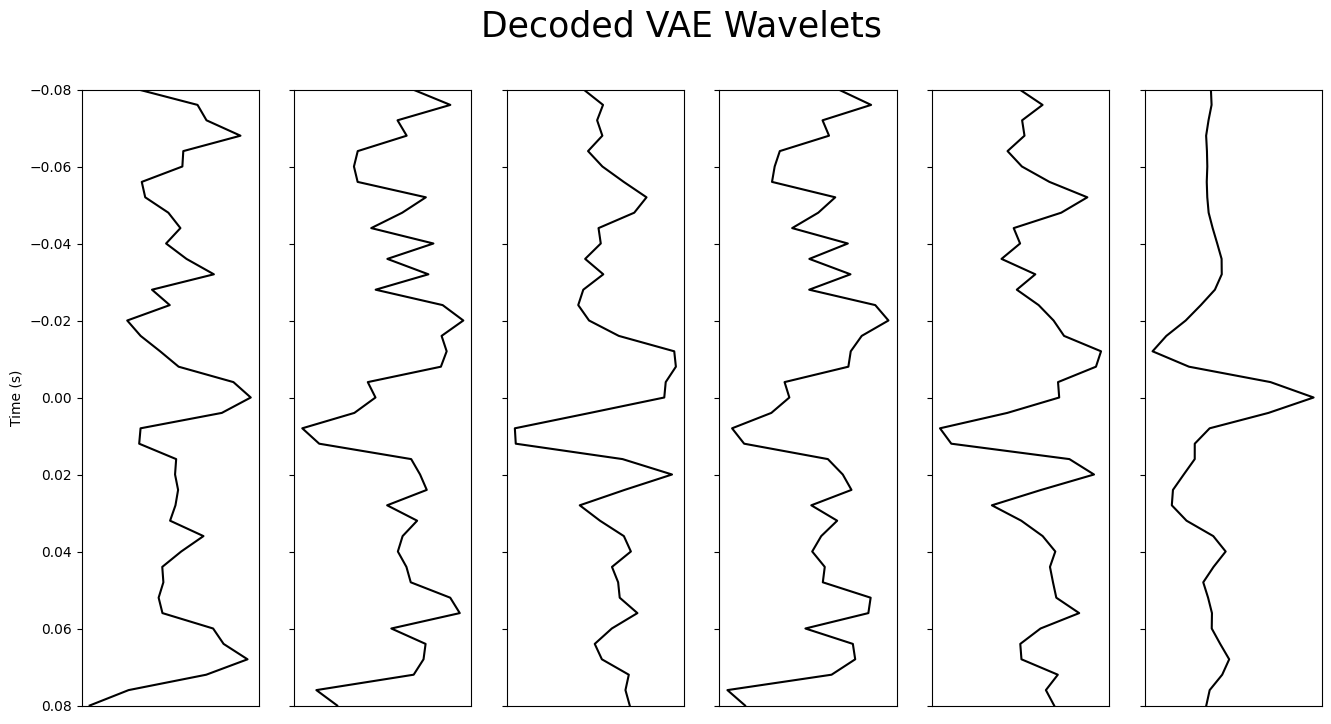

In [90]:
np.random.seed(2024)
latent = np.random.normal(size=(6, latent_dim))
vae_wavelets = va_decoder.predict(latent)
plot_wavelets(vae_wavelets, np.arange(6), 'Decoded VAE Wavelets')

In [93]:
n_clusters = 5

# use random_state for reproducibility
k_means_vae = KMeans(n_clusters=n_clusters,
                 n_init='auto',
                 random_state=2024)
k_means_vae.fit(encoded_vae_wavelets)

KMeans(n_clusters=5, n_init='auto', random_state=2024)

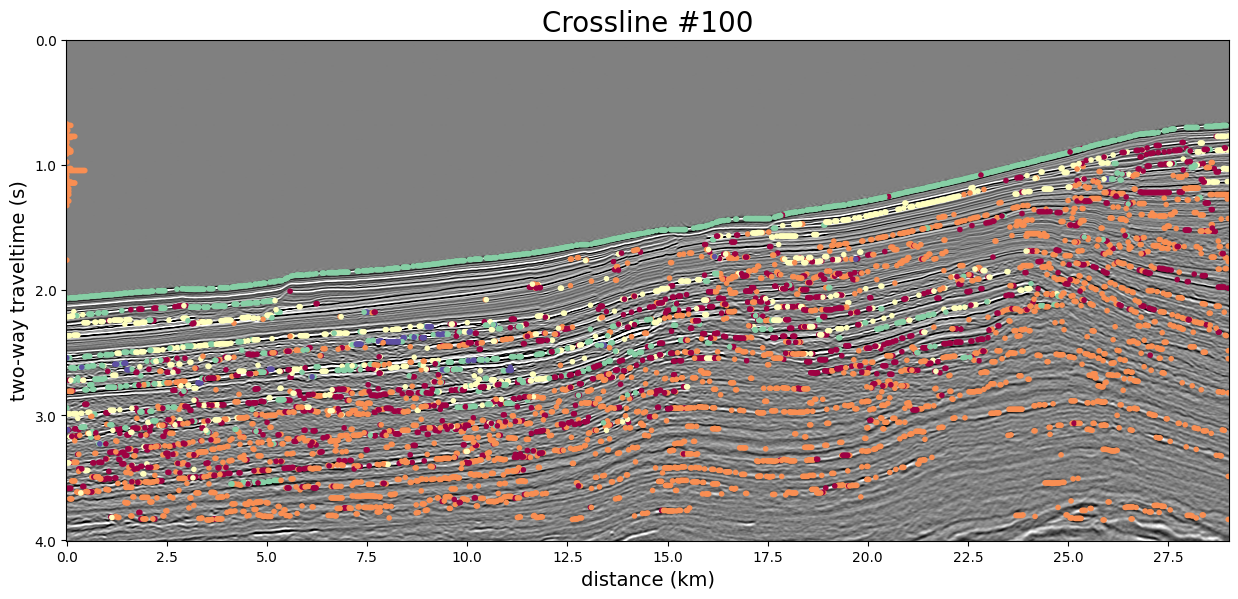

In [94]:
pick_marks = np.array(picks_r)
pick_colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(15, 7.5))
plot_seismic(section, 'Crossline #100')
plt.scatter(pick_marks[:, 0], pick_marks[:, 1],
            color=pick_colors[k_means_vae.labels_],
            marker='.')
plt.show()

### Discussion
From inserting another hidden layer 41-21-12 in encoder and 12-21-41 in decoder, seem the wavelet show shifting upward a little bit. However, from crossline plot after k-mean clustering show a bit better performance in clustering than less hidden layer.

## <div style="color:red">Bonus Task</div>

T-SNE (T-distributed Stochastic Neighbor Embedding) is a statistical technique for visualizing high-dimensional objects by projecting them into a 2-D or 3-D space. It is applicable for visualizing relationships among multidimensional clusters.

* Van der Maaten, L. and Hinton, G., 2008. [Visualizing data using t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbcl). Journal of machine learning research, 9(11).
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [95]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5)
embedded_wavelets = tsne.fit_transform(encoded_wavelets)
embedded_wavelets.shape

(7539, 2)

A key tunable parameter in T-SNE is <code>perplexity</code>. It may affect the topological relationship between embeddings.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_t_sne_perplexity_001.png)
* https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html

In [96]:
TSNE?

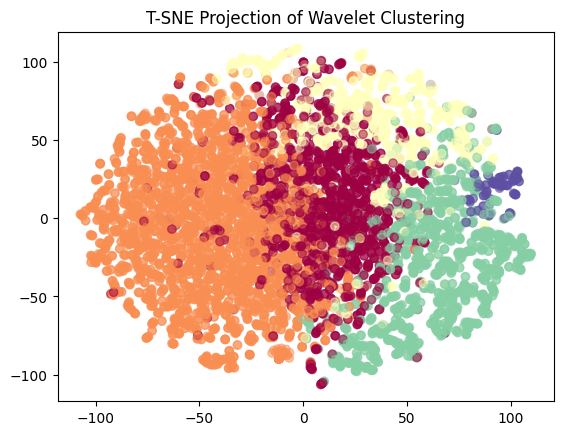

In [97]:
plt.scatter(embedded_wavelets[:, 0],
            embedded_wavelets[:, 1],
            color=pick_colors[k_means.labels_], alpha=0.5)
plt.title("T-SNE Projection of Wavelet Clustering")
plt.show()

**Bonus task**: perform cluster analysis of wavelets using the variational autoencoder defined above and visualize the result using T-SNE.

In [98]:
tsne_vae = TSNE(n_components=2, perplexity=5)
tsne_emb_vae_wavelets = tsne_vae.fit_transform(encoded_vae_wavelets)
tsne_emb_vae_wavelets.shape

(7539, 2)

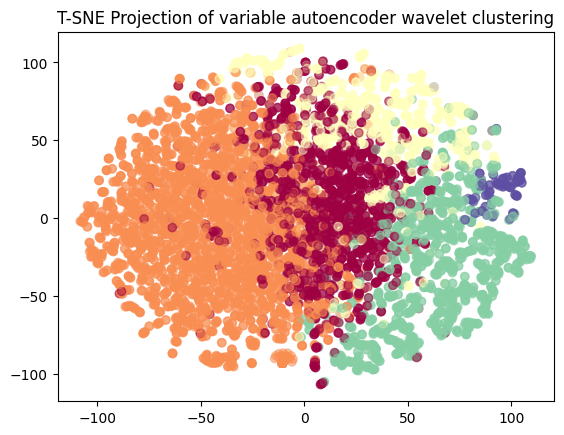

In [99]:
plt.scatter(tsne_emb_vae_wavelets[:, 0],
            tsne_emb_vae_wavelets[:, 1],
            color=pick_colors[k_means.labels_], alpha=0.5)
plt.title("T-SNE Projection of variable autoencoder wavelet clustering")
plt.show()